# pyWBM Future Cleaning
- This code is used for cleaning and processing future pyWBM & LOCA2 projections
- Allows us to take this data (panel) and use our coefficients from notebook 5 for future projections

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import dask
import os
import glob as glob
import cftime 
import warnings
warnings.filterwarnings("ignore")

## Growing degree days

In [2]:
from functions_2a import degreeDays, yearlyCalculationSum

### Filepaths & Inputs

In [3]:
# get cmip6 model names used in loca2, the full path for reference = "/storage/group/pches/default/public/LOCA2/ACCESS-CM2/0p0625deg/r1i1p1f1/ssp245/tasmin"
base_loca_paths_for_models = "/storage/group/pches/default/public/LOCA2/"
models = sorted(glob.glob(f"{base_loca_paths_for_models}*"))
model_names = [os.path.basename(m) for m in models][:-2]

# ssp scenarios used in pyWBM are 245 and 370
ssps = ["245", "370"]

# intitalizataions, only using r1i1p1f1 for now, some runs have more than 1 init
initializations = ["r1i1p1f1"]

# loca2 is in chunks of ~30 years 
time_frames = ["2015-2044", "2045-2074", "2075-2100"]

nldas_lsm = "VIC"

# this is the soil_moiture base path
pyWBM_file_path_base = "/storage/group/pches/default/users/dcl5300/wbm_soilM_uc_2024_DATA/projections/eCONUS/out/LOCA2"

# soil moisture historical normal 
soil_moisture_normal_file_path = f"/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/{nldas_lsm}_seasonal_average_alltime_average_soilmoisture.nc"

# some arbritrary pyWBM run for regridding
arbritrary_pyWBM_run = f'/storage/group/pches/default/users/dcl5300/wbm_soilM_uc_2024_DATA/projections/eCONUS/out/LOCA2/ACCESS-CM2_r1i1p1f1_ssp245_VIC_kge.nc'

In [39]:
def process_year(ds_combined, year, ds_soilpyWBM_regrid, ds_soil_normal_on_wbm_grid, ds_soilpyWBM_initial, model_name_i, initialization_i, ssp_i):
    '''
    this is processing each year, input from the process model function and its usefull-ness is to allow smaller tasks for more dask workers 
    inputs
    - ds combined which is just loca2 tamx & tmin
    - year single year for parallel-ness
    - ds_soil_normal_on_wbm_grid normal soil moisture
    - ds_soilpyWBM_initial as the appropriate pyWBM scenario which is not being opened repeatedly
    - model_name_i (cmip6 model)
    - initialization_i (initlization scenario)
    - ssp_i (the ssp scenario of interest)
    outputs
    - combined_dataset_bins which is a single year of processesd values
    '''
    ds_slice = ds_combined.sel(time=slice(f"{year}-04-01", f"{year}-09-30"))
    ds_slice = ds_slice.assign_coords(lon=((ds_slice.lon + 180) % 360) - 180).sortby("lon")
    land_mask = ds_slice.tmax.isel(time=0).notnull().copy(deep=True)
    
    # calculate degree days (assuming degreeDays is defined elsewhere)
    gdd_future = degreeDays(ds_slice, 'gdd')

    # Convert year to datetime (e.g. Jan 1st of each year)
    gdd_future_mask = gdd_future.where(land_mask)
    gdd_future_regrid = gdd_future_mask.interp(
        lat=ds_soilpyWBM_regrid.lat, 
        lon=ds_soilpyWBM_regrid.lon, 
        method="linear",
        kwargs={"fill_value": np.nan}
    ).transpose('lat', 'lon', 'time')
    
    edd_future = degreeDays(ds_slice, 'edd')
    edd_future_mask = edd_future.where(land_mask)
    edd_future_regrid = edd_future_mask.interp(
        lat=ds_soilpyWBM_regrid.lat, 
        lon=ds_soilpyWBM_regrid.lon, 
        method="linear",
        kwargs={"fill_value": np.nan}
    ).transpose('lat', 'lon', 'time')

    ds_soilpyWBM_year = ds_soilpyWBM_initial.sel(time=slice(f"{year}-04-01", f"{year}-09-30")).transpose('lat', 'lon', 'time')

    ds_soil_normal_on_wbm_grid_masked = ds_soil_normal_on_wbm_grid.where(~np.isnan(ds_soilpyWBM_year))
    ds_soil_normal_on_wbm_grid_masked = ds_soil_normal_on_wbm_grid_masked.transpose('lat', 'lon', 'time')
    
    deviation_from_normal = ds_soilpyWBM_year - ds_soil_normal_on_wbm_grid_masked.soilMoist
    
    #try:
    mask = ~np.isnan(ds_soilpyWBM_year.isel(time=0).soilMoist)
    edd_future_masked = edd_future_regrid.where(mask)
    gdd_future_masked = gdd_future_regrid.where(mask)
    # Define bin conditions and compute all bins in one pass using a dictionary comprehension
    
    if isinstance(edd_future_masked, xr.Dataset):
        edd_future_masked = edd_future_masked['soilMoist']
        
    if isinstance(gdd_future_masked, xr.Dataset):
        gdd_future_masked = gdd_future_masked['soilMoist']
        
    edd_future_masked = edd_future_masked.assign_coords(time=edd_future_masked.time.dt.floor('D'))
    deviation_from_normal, edd_future_masked = xr.align(deviation_from_normal, edd_future_masked, join='right')
    
    # Create binned EDD DataArrays based on the deviation thresholds.
    ds_bin_plus75 = xr.where(deviation_from_normal.soilMoist >= 75, edd_future_masked, 0)
    ds_bin_plus25_75 = xr.where((deviation_from_normal.soilMoist < 75) & (deviation_from_normal.soilMoist > 25), edd_future_masked, 0)
    ds_bin_minus25_plus25 = xr.where((deviation_from_normal.soilMoist <= 25) & (deviation_from_normal.soilMoist >= -25), edd_future_masked, 0)
    ds_bin_minus25_75 = xr.where((deviation_from_normal.soilMoist > -75) & (deviation_from_normal.soilMoist < -25), edd_future_masked, 0)
    ds_bin_minus75 = xr.where(deviation_from_normal.soilMoist <= -75, edd_future_masked, 0)
    
    # Sum the EDD values over the time dimension for each bin.
    ds_bin_plus75 = ds_bin_plus75.sum(dim='time')
    ds_bin_plus25_75 = ds_bin_plus25_75.sum(dim='time')
    ds_bin_minus25_plus25 = ds_bin_minus25_plus25.sum(dim='time')
    ds_bin_minus25_75 = ds_bin_minus25_75.sum(dim='time')
    ds_bin_minus75 = ds_bin_minus75.sum(dim='time')
    
    # Build the final combined dataset. 
    combined_dataset_bins = xr.Dataset({
        "gdd": gdd_future_masked.sum(dim='time'),
        "edd_plus75": ds_bin_plus75,
        "edd_plus25_75": ds_bin_plus25_75,
        "edd_minus25_plus25": ds_bin_minus25_plus25,
        "edd_minus25_75": ds_bin_minus25_75,
        "edd_minus75": ds_bin_minus75
    })
    
    return combined_dataset_bins
    #except Exception as e:
    #    print(f"{year} year error, pass this year:", e)
    #    return xr.Dataset()  
        
def process_model(model_name_i, initialization_i, ssp_i, ds_soilpyWBM_regrid, ds_soil_normal_on_wbm_grid):
    '''
    input parameters that specify pyWBM run, and processes for yearly binned dday, gdd, etc. 
    This links to a process year dask function allowing for more parallel-ness
    inputs
    - model_name_i (i.e. MIROC6)
    - initialization_i (i.e. r1i1p1f1)
    - ssp_i (i.e. 370)
    - ds_soilpyWBM_regrid which is some random pyWBM run which is regridded
    - ds_soil_normal_on_wbm_grid which is soil normal for corresponding LSM, only VIC for now
    outputs
    - dataset which has gdd, and binned edd 
    '''
    # this is the pyWBM combinations, eventually will need to be looped through 
    pywbm_combinations = sorted(glob.glob(f"{pyWBM_file_path_base}/{model_name_i}_{initialization_i}_ssp{ssp_i}_{nldas_lsm}*"))
    ds_soilpyWBM_initial = xr.open_dataset(pywbm_combinations[0])#.chunk({"lon": 100, "lat": 100, "time": "auto"})
    ds_soilpyWBM_initial['time'] = ds_soilpyWBM_initial.indexes['time'].to_datetimeindex()
    
    ds_combined = None  
    
    for time_frame_i in time_frames[:1]:
        # tmax file
        file_path_i_tmax = f"{base_loca_paths_for_models}{model_name_i}/0p0625deg/{initialization_i}/ssp{ssp_i}/tasmax"
        file_name_i_tmax = f"tasmax.{model_name_i}.ssp{ssp_i}.{initialization_i}.{time_frame_i}.LOCA_16thdeg_v20220413.nc"
        # tmin file
        file_path_i_tmin = f"{base_loca_paths_for_models}{model_name_i}/0p0625deg/{initialization_i}/ssp{ssp_i}/tasmin"
        file_name_i_tmin = f"tasmin.{model_name_i}.ssp{ssp_i}.{initialization_i}.{time_frame_i}.LOCA_16thdeg_v20220413.nc"
        
        # combing them for usage in degree day calculation
        try:
            ds_tmax = xr.open_dataset(f"{file_path_i_tmax}/{file_name_i_tmax}").rename({"tasmax": "tmax"}) # , chunks='auto'
            ds_tmin = xr.open_dataset(f"{file_path_i_tmin}/{file_name_i_tmin}").rename({"tasmin": "tmin"}) # , chunks='auto'
            ds_combined = xr.merge([ds_tmax, ds_tmin]) 
            
            
        except Exception:
            print(f"Issue with file location, skipping {file_path_i_tmax}/{file_name_i_tmax} or {file_path_i_tmin}/{file_name_i_tmin}")
            break

        # this inputs some big daily chunked dataset, and outputs the gdd & edd binned using pyWBM futures
        
    if ds_combined is None:
        print(f"Skipping process_model for {model_name_i}, {initialization_i}, ssp {ssp_i}: ds_combined was not assigned.")
        return
    
    try:
        start_year = int(ds_combined.time.dt.year.values[0])
        if start_year == 2015:
            start_year = 2016
        end_year = int(ds_combined.time.dt.year.values[-1])
    
        delayed_years = []
        for year in range(start_year, end_year + 1)[:4]:
            # Create a delayed task for each year
            delayed_task = dask.delayed(process_year)(
                ds_combined, year, ds_soilpyWBM_regrid, ds_soil_normal_on_wbm_grid,
                ds_soilpyWBM_initial, model_name_i, initialization_i, ssp_i
            )
            delayed_years.append(delayed_task)
    
        # return a delayed concatenation of the yearly datasets
        return dask.delayed(xr.concat)(delayed_years, dim="time")
    except Exception as e:
        print("Error in processing model:", e)
        return

## utilize dask for loading large dataset at end

In [5]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    account="open",
    cores=2,
    memory="200GiB",
    walltime="03:00:00",
    processes=1
)

cluster.scale(jobs=4)

In [6]:
from dask.distributed import Client

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://146.186.150.14:8787/status,
Dashboard: http://146.186.150.14:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://146.186.150.14:34087,Workers: 0
Dashboard: http://146.186.150.14:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Analysis / Calculations

In [69]:
# each loca2 file is 10GB (large)
# first lets get some base pyWBM run, & base historical normal to use for future regridding
# by getting ds_soil_normal_on_wbm_grid we can use it without issue for any pyWBM anomaly vs the historical time frame
ds_soilpyWBM_regrid = (xr.open_dataset(arbritrary_pyWBM_run))
ds_soil_normal = xr.open_dataset(soil_moisture_normal_file_path).SoilM_0_100cm
ds_soil_normal_on_wbm_grid = ds_soil_normal.interp(
    lat=ds_soilpyWBM_regrid.lat,
    lon=ds_soilpyWBM_regrid.lon,
    method="linear"  # or "nearest" if you prefer
).persist()

delayed_tasks = []
for model_name_i in model_names[:2]:
    for initialization_i in initializations:
        for ssp_i in ssps[:1]:
            delayed_tasks.append(
                dask.delayed(process_model)(
                    model_name_i, initialization_i, ssp_i,
                    ds_soilpyWBM_regrid, ds_soil_normal_on_wbm_grid
                )
            )

# Compute all tasks in parallel

In [73]:
results = dask.compute(*delayed_tasks)

In [ ]:
for dask_delayed_task_i_model in results:
    combined_dataset_bins = dask.compute(dask_delayed_task_i_model.load())[0]

In [64]:
combined_dataset_bins.to_netcdf('checkingsize.nc')

In [ ]:
delayed_tasks[0].visualize("my_graph.svg")

gdd


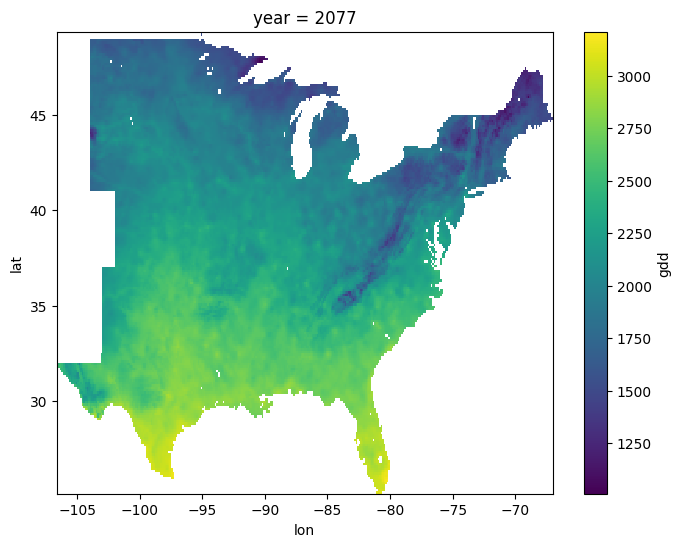

edd_plus75


In [ ]:
keys_single_place = list(combined_dataset_bins.keys())
for key_i in keys_single_place:
    print(key_i)
    plt.figure(figsize=(8,6))
    plt.title(f"{key_i} {year} {model_name_i} {initialization_i} ssp{ssp_i} {time_frame_i}", fontsize=14)
    data = combined_dataset_bins.isel(year=0)[key_i].compute()
    data.plot()
    plt.show()
    plt.close()